In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from keras.layers import Embedding
import proplot as pplt
from kmodes.kprototypes import KPrototypes
import plotly.express as px

import warnings
warnings.filterwarnings('ignore') 

In [2]:
df =  pd.read_csv("Data_test.csv",sep=";")

In [3]:
df.head()

,ID,Customer ID,City Code,Region Code,Accomodation Ownership,Insurance Type,Age,Married,Plan Code,Policy Duration,Policy Type,Policy Category,Premium Amount,Claim
0,32003,81040.0,C3,3029,Rented,Individual,65.0,No,NaN,NaN,NaN,22,40171.0,1
1,32285,88349.0,C4,2583,Rented,Individual,19.0,No,X2,NaN,NaN,12,13308.0,0
2,2530,80799.0,C6,4479,Rented,Individual,24.0,No,X2,NaN,NaN,2,41781.0,0
3,43305,72065.0,C11,267,Owned,Individual,66.0,No,X3,14+,2.0,22,15383.0,0
4,15714,84093.0,C2,4534,Owned,Individual,52.0,No,X1,14+,3.0,3,43924.0,0


In [4]:
df.columns = ['ID', 'Cust_ID', 'City_Code', 'Reg_Code', 'Accom_Own', 'Ins_Type', 'Age_Entry', 'Marital_Stat', 'Plan_Code', 'Pol_Dur',
                'Pol_Type', 'Pol_Cat', 'Prem_Amnt', 'Claim']

In [5]:
df.describe()

,ID,Cust_ID,Reg_Code,Age_Entry,Pol_Type,Pol_Cat,Prem_Amnt,Claim
count,50882.000000,50869.000000,50882.000000,50874.000000,30631.000000,50882.000000,50871.000000,50882.000000
mean,25441.500000,79993.806542,1732.788707,42.753568,2.439228,15.115188,30209.212459,0.239947
std,14688.512535,5766.505723,1424.081652,17.836079,1.025923,6.340663,15257.341750,0.427055
min,1.000000,70000.000000,1.000000,-20.000000,1.000000,1.000000,-15002.000000,0.000000
25%,12721.250000,74991.000000,523.000000,27.000000,1.000000,12.000000,19947.500000,0.000000
50%,25441.500000,80002.000000,1391.000000,40.000000,3.000000,17.000000,29874.000000,0.000000
75%,38161.750000,84986.000000,2667.000000,57.000000,3.000000,20.000000,40011.500000,0.000000
max,50882.000000,90000.000000,6194.000000,1000.000000,4.000000,22.000000,1000000.000000,1.000000


In [6]:
import statistics

modus_plan_code = statistics.mode(df["Plan_Code"])
modus_pol_dur = statistics.mode(df["Pol_Dur"])
modus_pol_type = statistics.mode(df["Pol_Type"])
median_age = df["Age_Entry"].median()
median_prem_amn = df["Prem_Amnt"].median()

In [7]:
df['Plan_Code'].fillna(modus_plan_code, inplace=True)
df['Pol_Dur'].fillna("14+", inplace=True)
df['Pol_Type'].fillna(modus_pol_type, inplace=True)
df['Age_Entry'].fillna(median_age, inplace=True)
df['Prem_Amnt'].fillna(median_prem_amn, inplace=True)

In [8]:
df.dropna(inplace=True)

In [9]:
df["Age_Entry"] = np.where(df["Age_Entry"] >75, median_age,df['Age_Entry'])
df["Age_Entry"] = np.where(df["Age_Entry"] <0, median_age,df['Age_Entry'])

In [10]:
max_prem_treshold = df["Prem_Amnt"].quantile(0.999)
min_prem_treshold = df["Prem_Amnt"].quantile(0.001)

In [11]:
max_prem_treshold, min_prem_treshold

(50000.0, 3173.984)

In [12]:
df = df[(df.Prem_Amnt>min_prem_treshold)&(df.Prem_Amnt<max_prem_treshold)]

In [13]:
df["Ins_Type"] = np.where(df["Ins_Type"] == "Individua","Individual",df['Ins_Type'])
df["Ins_Type"] = np.where(df["Ins_Type"] == "Sendiri","Individual",df['Ins_Type'])
df["Ins_Type"] = np.where(df["Ins_Type"] == "joint","Joint",df['Ins_Type'])
df["Ins_Type"] = np.where(df["Ins_Type"] == "Gabungan","Joint",df['Ins_Type'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50766 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            50766 non-null  int64  
 1   Cust_ID       50766 non-null  float64
 2   City_Code     50766 non-null  object 
 3   Reg_Code      50766 non-null  int64  
 4   Accom_Own     50766 non-null  object 
 5   Ins_Type      50766 non-null  object 
 6   Age_Entry     50766 non-null  float64
 7   Marital_Stat  50766 non-null  object 
 8   Plan_Code     50766 non-null  object 
 9   Pol_Dur       50766 non-null  object 
 10  Pol_Type      50766 non-null  float64
 11  Pol_Cat       50766 non-null  int64  
 12  Prem_Amnt     50766 non-null  float64
 13  Claim         50766 non-null  int64  
dtypes: float64(4), int64(4), object(6)
memory usage: 5.8+ MB


In [15]:
df

,ID,Cust_ID,City_Code,Reg_Code,Accom_Own,Ins_Type,Age_Entry,Marital_Stat,Plan_Code,Pol_Dur,Pol_Type,Pol_Cat,Prem_Amnt,Claim
0,32003,81040.0,C3,3029,Rented,Individual,65.0,No,X1,14+,3.0,22,40171.0,1
1,32285,88349.0,C4,2583,Rented,Individual,19.0,No,X2,14+,3.0,12,13308.0,0
2,2530,80799.0,C6,4479,Rented,Individual,24.0,No,X2,14+,3.0,2,41781.0,0
3,43305,72065.0,C11,267,Owned,Individual,66.0,No,X3,14+,2.0,22,15383.0,0
4,15714,84093.0,C2,4534,Owned,Individual,52.0,No,X1,14+,3.0,3,43924.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50877,42509,83742.0,C1,1801,Owned,Individual,75.0,No,X1,14+,3.0,18,22505.0,0
50878,30647,85810.0,C4,1746,Owned,Individual,31.0,No,X5,2.0,2.0,7,24212.0,0
50879,13645,82369.0,C17,328,Rented,Joint,55.0,Yes,X1,10.0,3.0,21,17270.0,0
50880,13989,77662.0,C3,1592,Owned,Individual,57.0,No,X5,14+,3.0,18,32658.0,0


In [16]:
for col in df.columns:
    print(col, '\t: ', len(df[col].unique()), 'label')

ID 	:  50766 label
Cust_ID 	:  18409 label
City_Code 	:  36 label
Reg_Code 	:  5315 label
Accom_Own 	:  2 label
Ins_Type 	:  2 label
Age_Entry 	:  62 label
Marital_Stat 	:  2 label
Plan_Code 	:  9 label
Pol_Dur 	:  15 label
Pol_Type 	:  4 label
Pol_Cat 	:  22 label
Prem_Amnt 	:  28710 label
Claim 	:  2 label


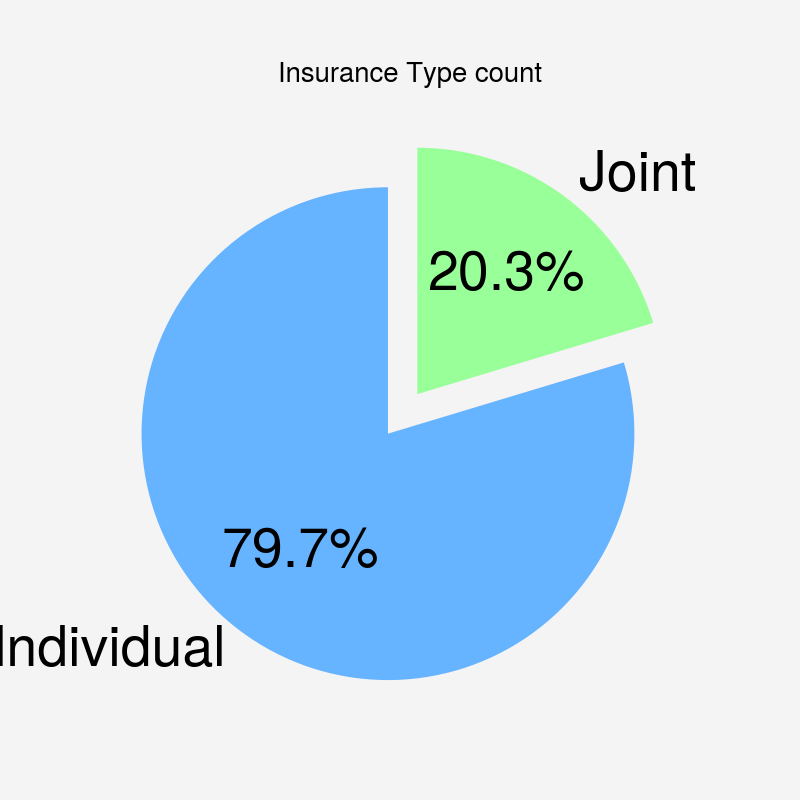

<Figure size 400x400 with 0 Axes>

In [17]:
def pie_chart(df, column ,explode , labels,title,no):
    
    plt.pie(df[column].value_counts(),
            explode=explode,    #explode=[0.04,0]
            startangle=90, 
            autopct='%1.1f%%',
            labels=labels, #labels=['Males','Females']
            colors = ['#66b3ff','#99ff99'],
            pctdistance=.6,
            textprops={'fontsize': 20})
    plt.title(title)
    plt.figure(no)

pie_chart(df, "Ins_Type" ,[0.15,0.05], ['Individual',"Joint"],"Insurance Type count",0)

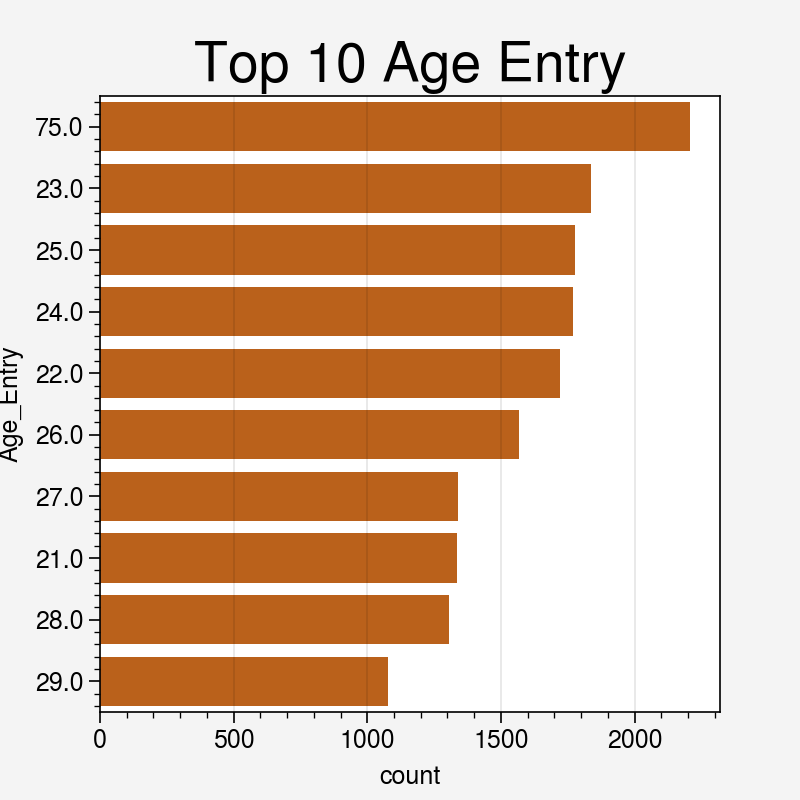

In [18]:
base_color = sns.color_palette()[1]

sns.countplot(y = 'Age_Entry',color= base_color, data = df, order = df.Age_Entry.value_counts().head(10).index)

plt.title("Top 10 Age Entry", fontsize = 20);

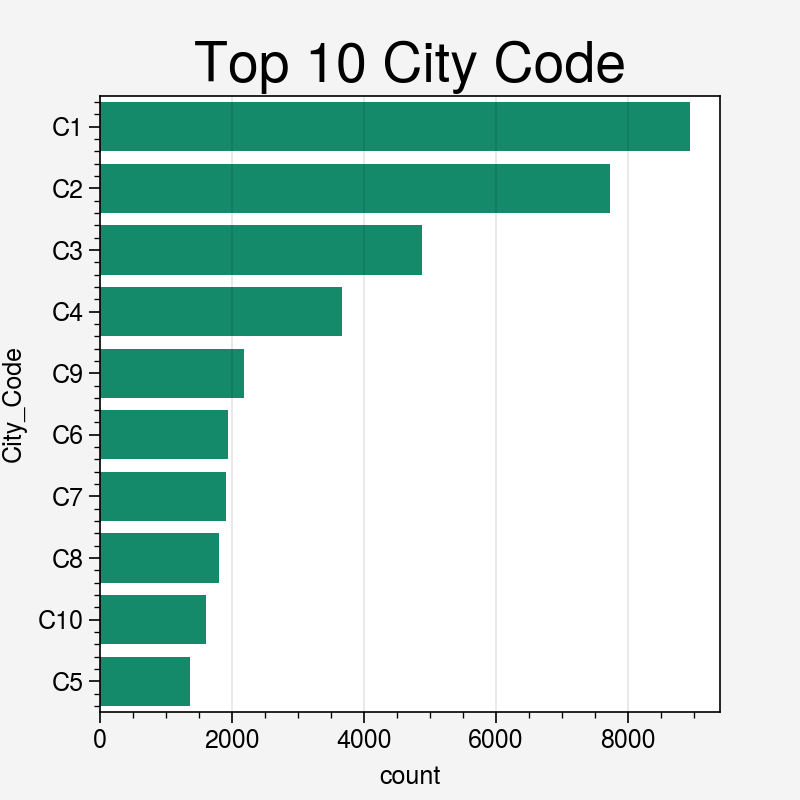

In [19]:
base_color = sns.color_palette()[2]

sns.countplot(y = 'City_Code',color= base_color, data = df, order = df.City_Code.value_counts().head(10).index)

plt.title("Top 10 City Code", fontsize = 20);

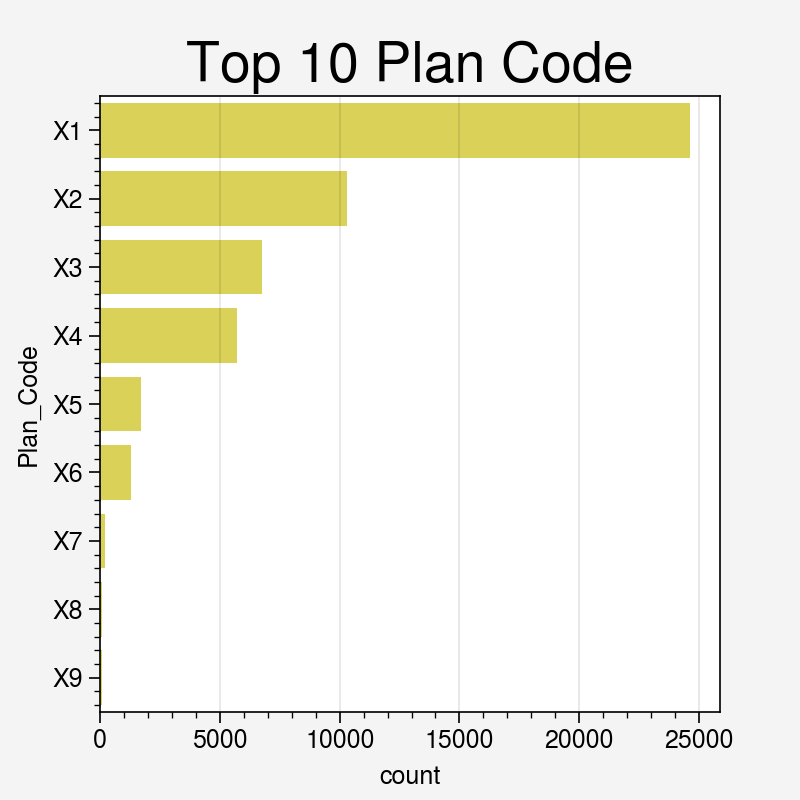

In [20]:
base_color = sns.color_palette()[4]

sns.countplot(y = 'Plan_Code',color= base_color, data = df, order = df.Plan_Code.value_counts().head(10).index)

plt.title("Top 10 Plan Code", fontsize = 20);

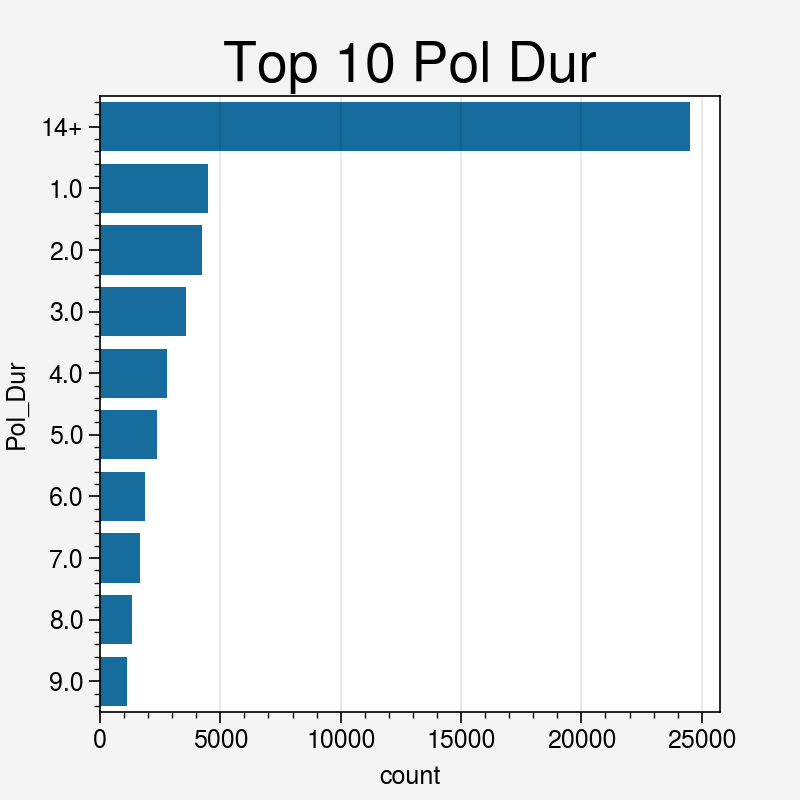

In [21]:
base_color = sns.color_palette()[0]

sns.countplot(y = 'Pol_Dur',color= base_color, data = df, order = df.Pol_Dur.value_counts().head(10).index)

plt.title("Top 10 Pol Dur", fontsize = 20);

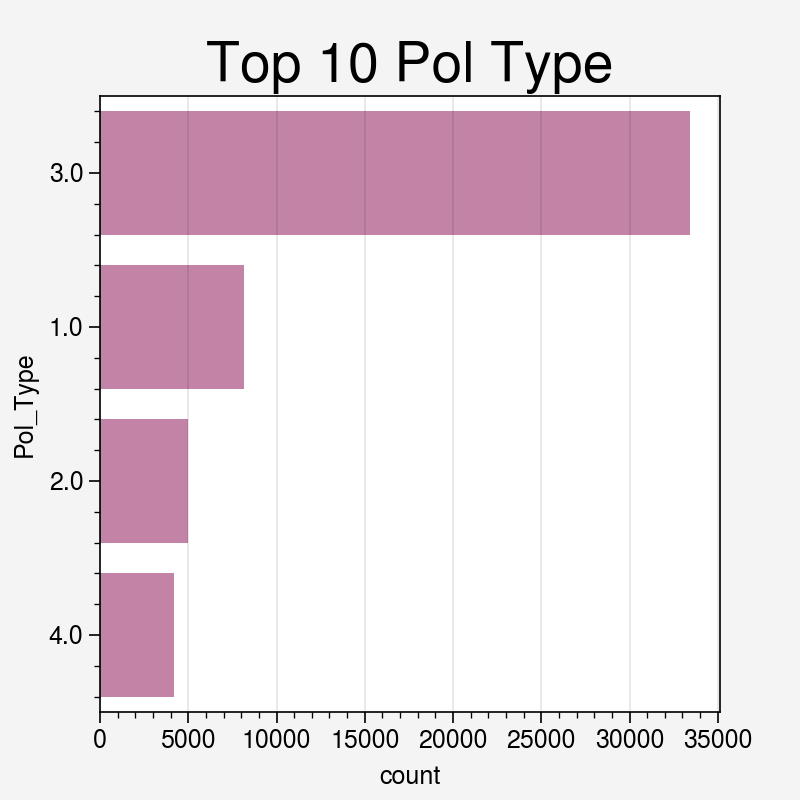

In [22]:
base_color = sns.color_palette()[3]

sns.countplot(y = 'Pol_Type',color= base_color, data = df, order = df.Pol_Type.value_counts().head(10).index)

plt.title("Top 10 Pol Type", fontsize = 20);

## Feature Engineering

In [23]:
df.head(1)

,ID,Cust_ID,City_Code,Reg_Code,Accom_Own,Ins_Type,Age_Entry,Marital_Stat,Plan_Code,Pol_Dur,Pol_Type,Pol_Cat,Prem_Amnt,Claim
0,32003,81040.0,C3,3029,Rented,Individual,65.0,No,X1,14+,3.0,22,40171.0,1


Cosine similarity is the measure of similarity between two vectors, by computing the cosine of the angle between two vectors projected into multidimensional space. It can be applied to items available on a dataset to compute similarity to one another via keywords or other metrics. Similarity between two vectors (A and B) is calculated by taking the dot product of the two vectors and dividing it by the magnitude value as shown in the equation below. We can simply say that the CS score of two vectors increases as the angle between them decreases.

In [25]:
df=df.drop(['ID','Reg_Code','Pol_Cat'],axis=1)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50766 entries, 0 to 50881
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cust_ID       50766 non-null  float64
 1   City_Code     50766 non-null  object 
 2   Accom_Own     50766 non-null  object 
 3   Ins_Type      50766 non-null  object 
 4   Age_Entry     50766 non-null  float64
 5   Marital_Stat  50766 non-null  object 
 6   Plan_Code     50766 non-null  object 
 7   Pol_Dur       50766 non-null  object 
 8   Pol_Type      50766 non-null  float64
 9   Prem_Amnt     50766 non-null  float64
 10  Claim         50766 non-null  int64  
dtypes: float64(4), int64(1), object(6)
memory usage: 6.7+ MB


### MODELING

In [27]:
df.head()

,Cust_ID,City_Code,Accom_Own,Ins_Type,Age_Entry,Marital_Stat,Plan_Code,Pol_Dur,Pol_Type,Prem_Amnt,Claim
0,81040.0,C3,Rented,Individual,65.0,No,X1,14+,3.0,40171.0,1
1,88349.0,C4,Rented,Individual,19.0,No,X2,14+,3.0,13308.0,0
2,80799.0,C6,Rented,Individual,24.0,No,X2,14+,3.0,41781.0,0
3,72065.0,C11,Owned,Individual,66.0,No,X3,14+,2.0,15383.0,0
4,84093.0,C2,Owned,Individual,52.0,No,X1,14+,3.0,43924.0,0


In [28]:
df1 = df.copy()
df1['Age_Entry'] = df1['Age_Entry'].astype(str)

In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50766 entries, 0 to 50881
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cust_ID       50766 non-null  float64
 1   City_Code     50766 non-null  object 
 2   Accom_Own     50766 non-null  object 
 3   Ins_Type      50766 non-null  object 
 4   Age_Entry     50766 non-null  object 
 5   Marital_Stat  50766 non-null  object 
 6   Plan_Code     50766 non-null  object 
 7   Pol_Dur       50766 non-null  object 
 8   Pol_Type      50766 non-null  float64
 9   Prem_Amnt     50766 non-null  float64
 10  Claim         50766 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 6.7+ MB


In [30]:
df1.shape

(50766, 11)

In [31]:
df1=df1[:10000]

In [32]:
df1.shape

(10000, 11)

In [33]:
df1.head()

,Cust_ID,City_Code,Accom_Own,Ins_Type,Age_Entry,Marital_Stat,Plan_Code,Pol_Dur,Pol_Type,Prem_Amnt,Claim
0,81040.0,C3,Rented,Individual,65.0,No,X1,14+,3.0,40171.0,1
1,88349.0,C4,Rented,Individual,19.0,No,X2,14+,3.0,13308.0,0
2,80799.0,C6,Rented,Individual,24.0,No,X2,14+,3.0,41781.0,0
3,72065.0,C11,Owned,Individual,66.0,No,X3,14+,2.0,15383.0,0
4,84093.0,C2,Owned,Individual,52.0,No,X1,14+,3.0,43924.0,0


In [34]:
def important_features(dataset):
    data=df1.copy()
    for i in range(0, dataset.shape[0]):
        data["combine"]=data["City_Code"]+'_'+data["Accom_Own"]+'_'+data["Age_Entry"]+'_'+data["Marital_Stat"]
    return data

In [35]:
data=important_features(df1)

In [36]:
data.head()

,Cust_ID,City_Code,Accom_Own,Ins_Type,Age_Entry,Marital_Stat,Plan_Code,Pol_Dur,Pol_Type,Prem_Amnt,Claim,combine
0,81040.0,C3,Rented,Individual,65.0,No,X1,14+,3.0,40171.0,1,C3_Rented_65.0_No
1,88349.0,C4,Rented,Individual,19.0,No,X2,14+,3.0,13308.0,0,C4_Rented_19.0_No
2,80799.0,C6,Rented,Individual,24.0,No,X2,14+,3.0,41781.0,0,C6_Rented_24.0_No
3,72065.0,C11,Owned,Individual,66.0,No,X3,14+,2.0,15383.0,0,C11_Owned_66.0_No
4,84093.0,C2,Owned,Individual,52.0,No,X1,14+,3.0,43924.0,0,C2_Owned_52.0_No


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10023
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cust_ID       10000 non-null  float64
 1   City_Code     10000 non-null  object 
 2   Accom_Own     10000 non-null  object 
 3   Ins_Type      10000 non-null  object 
 4   Age_Entry     10000 non-null  object 
 5   Marital_Stat  10000 non-null  object 
 6   Plan_Code     10000 non-null  object 
 7   Pol_Dur       10000 non-null  object 
 8   Pol_Type      10000 non-null  float64
 9   Prem_Amnt     10000 non-null  float64
 10  Claim         10000 non-null  int64  
 11  combine       10000 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1015.6+ KB


In [38]:
data["ids"]=[i for i in range(0,data.shape[0])]

In [39]:
data.head()

,Cust_ID,City_Code,Accom_Own,Ins_Type,Age_Entry,Marital_Stat,Plan_Code,Pol_Dur,Pol_Type,Prem_Amnt,Claim,combine,ids
0,81040.0,C3,Rented,Individual,65.0,No,X1,14+,3.0,40171.0,1,C3_Rented_65.0_No,0
1,88349.0,C4,Rented,Individual,19.0,No,X2,14+,3.0,13308.0,0,C4_Rented_19.0_No,1
2,80799.0,C6,Rented,Individual,24.0,No,X2,14+,3.0,41781.0,0,C6_Rented_24.0_No,2
3,72065.0,C11,Owned,Individual,66.0,No,X3,14+,2.0,15383.0,0,C11_Owned_66.0_No,3
4,84093.0,C2,Owned,Individual,52.0,No,X1,14+,3.0,43924.0,0,C2_Owned_52.0_No,4


In [40]:
##Importing vectoriser
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
vec=TfidfVectorizer()

In [41]:
vecs=vec.fit_transform(data["combine"].apply(lambda x: np.str_(x)))

In [42]:
vecs

<10000x2520 sparse matrix of type '<class 'numpy.float64'>'
	with 20000 stored elements in Compressed Sparse Row format>

In [43]:
vecs.shape

(10000, 2520)

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
sim=cosine_similarity(vecs) 

In [46]:
sim.shape

(10000, 10000)

In [47]:
# for example let us take the input is same as row number 0 so the recommeded system result is variable result who have result =1 or 0.99
data["result"]=[sim[i][0] for i in range(0,data.shape[0])]

In [48]:
data.sort_values(by=['result'],ascending=False)

,Cust_ID,City_Code,Accom_Own,Ins_Type,Age_Entry,Marital_Stat,Plan_Code,Pol_Dur,Pol_Type,Prem_Amnt,Claim,combine,ids,result
0,81040.0,C3,Rented,Individual,65.0,No,X1,14+,3.0,40171.0,1,C3_Rented_65.0_No,0,1.000000
8032,74759.0,C3,Rented,Individual,65.0,No,X2,14+,3.0,11475.0,1,C3_Rented_65.0_No,8012,1.000000
450,74594.0,C3,Rented,Individual,65.0,No,X1,14+,3.0,45210.0,0,C3_Rented_65.0_No,447,1.000000
4890,78545.0,C1,Owned,Individual,75.0,No,X1,14+,3.0,11151.0,0,C1_Owned_75.0_No,4874,0.027361
4724,82558.0,C1,Owned,Individual,75.0,No,X1,14+,3.0,45645.0,0,C1_Owned_75.0_No,4708,0.027361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4524,76728.0,C17,Rented,Joint,52.0,Yes,X1,4.0,1.0,47692.0,0,C17_Rented_52.0_Yes,4509,0.000000
1429,84325.0,C20,Rented,Joint,24.0,Yes,X2,2.0,3.0,40014.0,0,C20_Rented_24.0_Yes,1423,0.000000
8775,76739.0,C8,Owned,Joint,59.0,Yes,X2,11.0,1.0,34350.0,1,C8_Owned_59.0_Yes,8754,0.000000
6109,88302.0,C1,Owned,Joint,23.0,Yes,X1,14+,1.0,38555.0,0,C1_Owned_23.0_Yes,6092,0.000000


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10023
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cust_ID       10000 non-null  float64
 1   City_Code     10000 non-null  object 
 2   Accom_Own     10000 non-null  object 
 3   Ins_Type      10000 non-null  object 
 4   Age_Entry     10000 non-null  object 
 5   Marital_Stat  10000 non-null  object 
 6   Plan_Code     10000 non-null  object 
 7   Pol_Dur       10000 non-null  object 
 8   Pol_Type      10000 non-null  float64
 9   Prem_Amnt     10000 non-null  float64
 10  Claim         10000 non-null  int64  
 11  combine       10000 non-null  object 
 12  ids           10000 non-null  int64  
 13  result        10000 non-null  float64
dtypes: float64(4), int64(2), object(8)
memory usage: 1.1+ MB


In [50]:
def recommend(cust):
    cust_id=data[data.Cust_ID==cust]["ids"].values[0]
    scores=list(enumerate(sim[cust_id]))
    sorted_scores=sorted(scores,key=lambda x:x[1],reverse=True)
    sorted_scores=sorted_scores[1:]
    Poldur=[data[Poldur[0]==data["ids"]]["Pol_Dur"].values[0] for Poldur in sorted_scores]
    return Poldur

In [51]:
sorted_scores

NameError: name 'sorted_scores' is not defined

In [ ]:
def recommend_ten(Poldur_list):
    first_ten=[]
    count=0
    for Poldur in Poldur_list:
        if count > 9:
            break
        count+=1
        first_ten.append(Poldur)
    return first_ten

In [ ]:
lst=recommend("81040.0")
m=recommend_ten(lst)

In [ ]:
m

In [ ]:
data.head()